In [5]:
# Install all important libraries
%pip install yfinance
%pip install ta
%pip install optuna

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29411 sha256=d59f2b714a248f48c0e0cb3f46517fdb046e71f2d5d2a262bed304b083f9a517
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 7.8 MB/s eta 0:00:00


In [6]:
# import all libraries
from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volume import VolumeWeightedAveragePrice

import math
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors

In [7]:
# G10 USD-quoted pairs (exlcuding JPYUSD, NOKUSD, SEKUSD, CHFUSD) plus SGDUSD, HKDUSD and CNYUSD pairs
forex_pairs_dict = {
    "AUDUSD": "AUDUSD=X",
    "CADUSD": "EURCAD=X",
    "EURUSD": "EURUSD=X",
    "NZDUSD": "NZDUSD=X",
    "GBPUSD": "GBPUSD=X",
    "SGDUSD": "SGD=X",
    "HKDUSD": "HKD=X",
    "CNYUSD": "CNY=X"
}

In [8]:
# For event based backtesting, an imporatant concept is a bar.
# A bar is unit of data or information. A bar represents an event.
# Event based Backtesting will be based on new bars coming at not on full dataset.

# First we will build a commonclass,
# this will be utilised for all the common purposes like preparing data, plotting results, placing orders etc

In [41]:
class Common_Class():


 def __init__(self, symbol, start, end, interval, capital, transcation_cost, verbose = True, fast_atr_window = 5, slow_atr_window = 20, multiplier = 0.1):


   self.symbol = []
   self.start = start
   self.end = end
   self.interval = interval
   self.initial_capital = capital # this is the initial capital you want to trade with
   self.capital = {} # this capital will change depending on trades
   self.transaction_cost = transcation_cost # the transaction cost for trading
   self.quantity = {} # quantities to buy/sell
   self.position = {} # the trades in progress, long or short
   self.trades = {} # Number of trades
   self.verbose = verbose # if you want to see detailed output (logs)
   self.vol_window = 1 # volatility window
   self.fast_atr_window = fast_atr_window # fast ATR window
   self.slow_atr_window = slow_atr_window # slow ATR window
   self.multiplier = multiplier # multipler for position sizing based on ATR


   self.entry_price = {} # store entry price for stop loss and take profit
   self.streak = {} # store steak of buy/sell signals
   self.data = {}
   self.positions = {}
   self.prepare_data(symbol) # prepares the data




 def prepare_data(self,symbol):


   for index, (name, pair) in enumerate(symbol.items()):


       hist_forex = yf.Ticker(pair).history(start = self.start, end = self.end, interval = self.interval)


       self.symbol.append(name)
       self.capital[name] = self.initial_capital
       self.quantity[name] = 0
       self.position[name] = 0
       self.trades[name] = 0
       self.streak[name] = 0
       self.entry_price[name] = 0
       if index==0:
           bt_data = pd.DataFrame()
           bt_data["Close_Price"] = hist_forex["Close"]
           bt_data["High_Price"] = hist_forex["High"]
           bt_data["Low_Price"] = hist_forex["Low"]
           bt_data["Return"] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))


           # Calculate volatility
           bt_data["Volatility"] = bt_data["Return"].rolling(window=self.vol_window).std(ddof=0)*np.sqrt(252)


           # Calculate fast and slow ATR
           bt_data["Fast_ATR"] = AverageTrueRange(high=bt_data["High_Price"], low=bt_data["Low_Price"], close=bt_data["Close_Price"], window=self.fast_atr_window).average_true_range()
           bt_data["Slow_ATR"] = AverageTrueRange(high=bt_data["High_Price"], low=bt_data["Low_Price"], close=bt_data["Close_Price"], window=self.slow_atr_window).average_true_range()


           bt_data = bt_data.dropna()
           self.data[name] = bt_data


           '''
           #Rename columns to individual currency pairs
           bt_data.rename(columns={'Close_Price': f'{name}_Close_Price'}, inplace=True)
           bt_data.rename(columns={'Return': f'{name}_Return'}, inplace=True)
           bt_data.rename(columns={'Volatility': f'{name}_Volatility'}, inplace=True)
           '''
           # Dataframe for currency pairs correlation
           corr_data = pd.DataFrame()
           corr_data["Close_Price"] = hist_forex["Close"]
           corr_data.rename(columns={'Close_Price': f'{name}'}, inplace=True)




       else:
           temp_bt_data = pd.DataFrame()
           temp_bt_data["Close_Price"] = hist_forex["Close"]
           temp_bt_data["High_Price"] = hist_forex["High"]
           temp_bt_data["Low_Price"] = hist_forex["Low"]


           temp_bt_data["Return"] = np.log(temp_bt_data["Close_Price"] / temp_bt_data["Close_Price"].shift(1))


           # Calculate volatility
           temp_bt_data["Volatility"] = temp_bt_data["Return"].rolling(window=self.vol_window).std(ddof=0)*np.sqrt(252)


           # Calculate fast and slow ATR
           temp_bt_data["Fast_ATR"] = AverageTrueRange(high=temp_bt_data["High_Price"], low=temp_bt_data["Low_Price"], close=temp_bt_data["Close_Price"], window=self.fast_atr_window).average_true_range()
           temp_bt_data["Slow_ATR"] = AverageTrueRange(high=temp_bt_data["High_Price"], low=temp_bt_data["Low_Price"], close=temp_bt_data["Close_Price"], window=self.slow_atr_window).average_true_range()


           temp_bt_data = temp_bt_data.dropna()
           self.data[name] = temp_bt_data
           '''
           temp_bt_data.rename(columns={'Close_Price': f'{name}_Close_Price'}, inplace=True)
           temp_bt_data.rename(columns={'Return': f'{name}_Return'}, inplace=True)
           temp_bt_data.rename(columns={'Volatility': f'{name}_Volatility'}, inplace=True)
           '''
           temp_corr_data = pd.DataFrame()
           temp_corr_data["Close_Price"] = hist_forex["Close"]
           temp_corr_data.rename(columns={'Close_Price': f'{name}'}, inplace=True)


           #bt_data = pd.merge(bt_data, temp_bt_data, left_index=True, right_index=True)
           corr_data = pd.merge(corr_data, temp_corr_data, left_index=True, right_index=True)


   bt_data = bt_data.dropna()
   corr_data = corr_data.dropna()


   corr_matrix = corr_data.corr()


   self.corr_matrix = corr_matrix


 def moving_average(self,symbol):
   return sum(self.data[symbol]) / len(self.data[symbol])


 def correlation_graph(self):
   # Create a heatmap using seaborn
   plt.figure(figsize=(12, 10))
   sns.heatmap(self.corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
   plt.title('Correlation Matrix of Currency Pairs')
   plt.show()


   stacked_corr = self.corr_matrix.stack()
   filtered_corr = stacked_corr[stacked_corr < 1]
   sorted_corr = filtered_corr.sort_values(ascending=False)
   # print("--------------------------------------------------------")
   # print("Positively correlated currency pairs (highest to lowest)")
   # print("--------------------------------------------------------")
   # print(sorted_corr)


 def close_graph(self, symbol):
   plt.figure(figsize=(15, 5))
   plt.plot(self.data[symbol]["Close_Price"] ,color='black', label='Price', linestyle='dashed')
   plt.xlabel("Days")
   plt.ylabel("Price")
   plt.title("Close Prices of {}".format(symbol))
   plt.legend()
   plt.grid()
   plt.show()


 def strategy_return_graph(self, symbol):
   plt.figure(figsize=(15, 5))
   plt.plot(self.data[symbol]["Strategy_Returns"] ,color='black', label='Price', linestyle='dashed')
   plt.xlabel("Days")
   plt.ylabel("Price")
   plt.title("Close Prices of {}".format(symbol))
   plt.legend()
   plt.grid()
   plt.show()


 def return_date_price(self, symbol, bar):


   # A bar is a unit of data at a given time, depends on the interval you choose, it provides you OHLCV and time info
   # Since we have modeled close prices, we will get the price and date


   date = str(self.data[symbol].index[bar])[:10] #First 10 contains the date elements, rest is time
   price = self.data[symbol]["Close_Price"].iloc[bar]
   return date, price


 def realised_balance(self, symbol, bar):


   #Returns you the realised capital in your account at a given time period / bar


   date, price = self.return_date_price(symbol, bar)
   # print("Date :{} | Realised Balance: {:0.1f}".format(date,self.capital[symbol]))


 def unrealised_balance(self, symbol, bar):


   #Returns you the unrealised capital (trades in progress) in your account at a given time period / bar


   date, price = self.return_date_price(symbol, bar)
   ub = self.quantity[symbol] * price
   # # print("Date :{} | Unrealised Balance: {:0.1f}".format(date,ub))


 def total_balance(self, symbol, bar):


   #Unrealised plus realised


   date, price = self.return_date_price(symbol,bar)
   tb = self.quantity[symbol] *price + self.capital[symbol]
  # tb = self.quantity *price + self.capital
   # print("Date :{} | Total Balance of {}: {:0.1f}".format(date,symbol,tb))


 def buy_order(self,symbol,bar,quantity=None, dollar =None ):
   date, price = self.return_date_price(symbol,bar)
   if quantity == None:
     quantity = int(dollar/price)
   self.capital[symbol] = self.capital[symbol] - ((quantity * price)*(1 + self.transaction_cost)) # capital will be lost in buying
   self.quantity[symbol] = self.quantity[symbol] + quantity
   self.trades[symbol] = self.trades[symbol] + 1
   # if self.verbose:
   #   # print("Bought {} currency pair of {} at {:0.1f} per unit worth {:0.1f} $".format(quantity,symbol, price, quantity * price))
   #   self.realised_balance(symbol,bar)
   #   self.unrealised_balance(symbol,bar)
   #   self.total_balance(symbol,bar)




 def sell_order(self,symbol,bar,quantity=None, dollar=None ):
   date, price = self.return_date_price(symbol,bar)
   if quantity == None:
     quantity = int(dollar/price)
   self.capital[symbol] = self.capital[symbol] + ((quantity * price)*(1 - self.transaction_cost)) # capital will be added after selling
   self.quantity[symbol] = self.quantity[symbol] - quantity
   self.trades[symbol] = self.trades[symbol] + 1
   # if self.verbose:
   #   # print("Sold {} currency pair of {} at {:0.1f} per unit worth {:0.1f} $".format(quantity,symbol, price, quantity * price))
   #   self.realised_balance(symbol,bar)
   #   self.unrealised_balance(symbol,bar)
   #   self.total_balance(symbol,bar)


 def last_trade(self, symbol, bar):
   print(symbol)
   date, price = self.return_date_price(symbol,bar)
   last_quantity = self.quantity[symbol] # this variable to print and store as self.quantity will be set to 0 later
   self.capital[symbol] = self.capital[symbol] + self.quantity[symbol] * price
   self.quantity[symbol] = 0 # as no more quantity now. all will be settled
   self.trades[symbol] = self.trades[symbol] +1
   if True: #self.verbose:
     print("Closed open trades for {} currency pair of {} at {:0.1f} per unit worth {:0.1f} $".format(last_quantity,symbol, price, last_quantity * price))
     self.total_balance(symbol,bar)


     returns = (self.capital[symbol] - self.initial_capital) /self.initial_capital *100
     print("The total capital at end of strategy: {:0.1f}".format(self.capital[symbol]))
     print( "The strategy returns on investment are {:0.1f} %".format(returns))
     print( "Total trades by strategy are {:0.1f}".format(self.trades[symbol]))


     self.data[symbol]["Positions"] = self.positions[symbol]
     self.data[symbol]['Strategy_Returns'] = self.data[symbol]['Return'] * self.data[symbol]['Positions'].shift(1)
     log_returns = self.data[symbol]['Strategy_Returns'].sum()
     annual_ret = self.data[symbol]['Strategy_Returns'].mean() * 252
     annual_regular_ret = np.exp(annual_ret)-1
     annual_regular_std = (np.exp(self.data[symbol]["Strategy_Returns"])-1).std() * (252 **0.5)
     sharpe_ratio = annual_regular_ret/ annual_regular_std


     # Calculate Calmar ratio and drawdown
     self.data[symbol]["Cumulative_Returns"] = self.data[symbol]["Strategy_Returns"].cumsum()
     self.data[symbol]["Maximum_Returns"] = self.data[symbol]["Cumulative_Returns"].cummax()
     self.data[symbol]["drawdowns"] = (self.data[symbol]["Maximum_Returns"] - self.data[symbol]["Cumulative_Returns"])/self.data[symbol]["Maximum_Returns"]


     # Calculate win rate
     self.data[symbol]["wins"] = np.where(self.data[symbol]["Strategy_Returns"] > 0, 1, 0)
     wins = self.data[symbol]["wins"].sum()
     self.data[symbol]["losses"] = np.where(self.data[symbol]["Strategy_Returns"] < 0, 1, 0)
     losses = self.data[symbol]["losses"].sum()
     win_rate = round(wins/(losses + wins)*100, 2)


     pd.options.mode.use_inf_as_na = True
     max_drawdown = self.data[symbol]["drawdowns"].max()
     max_drawdown = round(max_drawdown, 2)
     Calmar_ratio = annual_regular_ret / max_drawdown
     Calmar_ratio = round(Calmar_ratio, 2)


     print( "The strategy total log returns on investment are {:0.2f} ".format(log_returns))
     print( "The strategy annual normal returns on investment are {:0.2f} ".format(annual_regular_ret))
     print( "The strategy win rate on investment is {:0.2f} % ".format(win_rate))
     print( "The strategy Sharpe ratio on investment are {:0.2f} ".format(sharpe_ratio))
     print( "The strategy maximum drawdown on investment are {:0.2f} % ".format(max_drawdown))
     print( "The strategy Calmar ratio on investment are {:0.2f} ".format(Calmar_ratio))
     return log_returns

### Bollinger Bands-RSI strategy

In [46]:
class RSI_BB_Strategy(Common_Class):


   def generate_signal(self, symbol, window_bol, window_bol_dev, window_rsi):
       int_bollinger = BollingerBands(close=self.data[symbol]["Close_Price"], window=window_bol, window_dev=window_bol_dev, fillna=False).bollinger_pband()
       int_rsi = RSIIndicator(close=self.data[symbol]["Close_Price"], window=window_rsi, fillna=False).rsi()
       self.data[symbol]['bollinger'] = int_bollinger
       self.data[symbol]['rsi'] = int_rsi


   def go_long(self,symbol, bar, quantity=None, dollar=None):
       if quantity:
         self.buy_order(symbol, bar, quantity = quantity) # to create new fresh order
       elif dollar:
         slowValueATR = self.data[symbol]["Slow_ATR"].iloc[bar]
         fastValueATR = self.data[symbol]["Fast_ATR"].iloc[bar]
         # if short volatility spikes up then modify size of trade
         if (fastValueATR > slowValueATR):
           if dollar == 'first':
             dollar = self.capital[symbol] * 0.4 * self.multiplier
           elif dollar == "second":
             dollar = self.capital[symbol] * 0.5 * self.multiplier
           elif dollar == "third":
             dollar = self.capital[symbol] * self.multiplier
         else:
           if dollar == 'first':
             dollar = self.capital[symbol] * 0.4
           elif dollar == "second":
             dollar = self.capital[symbol] * 0.5
           elif dollar == "third":
             dollar = self.capital[symbol]


         self.buy_order(symbol, bar, dollar = dollar)


   def go_short(self,symbol, bar, quantity=None, dollar=None):
       if quantity:
         self.sell_order(symbol, bar, quantity = quantity) # to create new fresh order
       elif dollar:
         slowValueATR = self.data[symbol]["Slow_ATR"].iloc[bar]
         fastValueATR = self.data[symbol]["Fast_ATR"].iloc[bar]
         # if short volatility spikes up then modify size of trade
         if (fastValueATR > slowValueATR):
           if dollar == 'first':
             dollar = self.capital[symbol] * 0.4 * self.multiplier
           elif dollar == "second":
             dollar = self.capital[symbol] * 0.5 * self.multiplier
           elif dollar == "third":
             dollar = self.capital[symbol] * self.multiplier
         else:
           if dollar == 'first':
             dollar = self.capital[symbol] * 0.4
           elif dollar == "second":
             dollar = self.capital[symbol] * 0.5
           elif dollar == "third":
             dollar = self.capital[symbol]


         self.sell_order(symbol, bar, dollar = dollar)


   def run_strategy(self, window_bol = 30, window_bol_dev = 2.4, window_rsi = 21, rsi_upper_bound = 85, bb_upper_bound = 85, rsi_lower_bound = 35, bb_lower_bound = 15, moving_window = 700):
       total_log_return = 0
       for symbol in self.symbol:
         self.position[symbol] = 0
         if symbol not in self.positions:
           self.positions[symbol] = []
         self.trades[symbol] = 0
         self.capital[symbol] = self.initial_capital


         self.generate_signal(symbol, window_bol, window_bol_dev, window_rsi)


         for bar in range(window_bol):
           self.positions[symbol].append(self.position[symbol])


         for bar in range(window_bol, len(self.data[symbol])):
           window_open = max(0, bar - moving_window)
           #check stop loss and take profit points
           if self.data[symbol]["Close_Price"].iloc[bar] <= self.entry_price[symbol] * 0.97 and self.entry_price[symbol]!=0 and self.quantity[symbol]>0:
             self.go_short(symbol, bar, quantity=abs(self.quantity[symbol]))
             self.position[symbol] = 0
             self.streak[symbol] = 0
             self.entry_price[symbol] = 0
             # print("--------")
             # print("Stop Loss")
             # print(self.streak[symbol])
           elif self.data[symbol]["Close_Price"].iloc[bar] >= self.entry_price[symbol] * 1.5 and self.entry_price[symbol]!=0 and self.quantity[symbol]>0:
             self.go_short(symbol, bar, quantity=abs(self.quantity[symbol]))
             self.position[symbol] = 0
             self.streak[symbol] = 0
             self.entry_price[symbol] = 0
             # print("--------")
             # print("Take Profit")
             # print(self.streak[symbol])
           elif self.data[symbol]["Close_Price"].iloc[bar] >= self.entry_price[symbol] * 1.03 and self.entry_price[symbol]!=0 and self.quantity[symbol]<0:
             self.go_long(symbol,bar, quantity=abs(self.quantity[symbol]))
             self.position[symbol] = 0
             self.streak[symbol] = 0
             self.entry_price[symbol] = 0
             # print("--------")
             # print("Stop Loss")
             # print(self.streak[symbol])
           elif self.data[symbol]["Close_Price"].iloc[bar] <= self.entry_price[symbol] * 0.5 and self.entry_price[symbol]!=0 and self.quantity[symbol]<0:
             self.go_long(symbol,bar, quantity=abs(self.quantity[symbol]))
             self.position[symbol] = 0
             self.streak[symbol] = 0
             self.entry_price[symbol] = 0
             # print("--------")
             # print("Take Profit")
             # print(self.streak[symbol])


           if self.streak[symbol] in [0]:
             if self.data[symbol]["rsi"].iloc[bar]>np.nanpercentile(self.data[symbol]["rsi"][window_open:bar], rsi_upper_bound) and self.data[symbol]["bollinger"].iloc[bar]>np.nanpercentile(self.data[symbol]["bollinger"][window_open:bar], bb_upper_bound):
               self.go_short(symbol, bar, dollar="first") # go with 40% of capital
               self.position[symbol] = -1
               self.streak[symbol] = -1
               self.entry_price[symbol] = self.data[symbol]["Close_Price"].iloc[bar]
               # print("--------")
               # print(self.streak[symbol])
               self.positions[symbol].append(self.position[symbol])
               continue


             if self.data[symbol]["rsi"].iloc[bar]<np.nanpercentile(self.data[symbol]["rsi"][window_open:bar], rsi_lower_bound) and self.data[symbol]["bollinger"].iloc[bar]<np.nanpercentile(self.data[symbol]["bollinger"][window_open:bar], bb_lower_bound):
               self.go_long(symbol, bar, dollar ="first") # go with 40% of capital
               self.position[symbol] = 1
               self.streak[symbol] = 1
               self.entry_price[symbol] = self.data[symbol]["Close_Price"].iloc[bar]
               # print("--------")
               # print(self.streak[symbol])
               self.positions[symbol].append(self.position[symbol])
               continue


           if self.streak[symbol] in [1]: # checking no position or short position
             if self.data[symbol]["rsi"].iloc[bar]>np.nanpercentile(self.data[symbol]["rsi"][window_open:bar], rsi_upper_bound) and self.data[symbol]["bollinger"].iloc[bar]>np.nanpercentile(self.data[symbol]["bollinger"][window_open:bar], bb_upper_bound):
               self.go_short(symbol, bar, quantity=self.quantity[symbol]) # sell all quantity owned
               self.go_short(symbol, bar, dollar = "first") # and go with 40% of capital
               self.position[symbol] = -1
               self.streak[symbol] = -1
               #self.entry_price[symbol] = self.data[symbol]["Close_Price"].iloc[bar]
               # print("--------")
               # print(self.streak[symbol])
               self.positions[symbol].append(self.position[symbol])
               continue


             if self.data[symbol]["rsi"].iloc[bar]<np.nanpercentile(self.data[symbol]["rsi"][window_open:bar], rsi_lower_bound) and self.data[symbol]["bollinger"].iloc[bar]<np.nanpercentile(self.data[symbol]["bollinger"][window_open:bar], bb_lower_bound):
               self.go_long(symbol, bar, dollar ="second") # go with another 30% of capital (50% * (1-40%))
               self.position[symbol] = 1
               self.streak[symbol] = 2
               #self.entry_price[symbol] = self.data[symbol]["Close_Price"].iloc[bar]
               # print("--------")
               # print(self.streak[symbol])
               self.positions[symbol].append(self.position[symbol])
               continue




           if self.streak[symbol] in [2]: # checking no position or short position
             if self.data[symbol]["rsi"].iloc[bar]>np.nanpercentile(self.data[symbol]["rsi"][window_open:bar], rsi_upper_bound) and self.data[symbol]["bollinger"].iloc[bar]>np.nanpercentile(self.data[symbol]["bollinger"][window_open:bar], bb_upper_bound):
               self.go_short(symbol, bar, quantity=self.quantity[symbol]*0.5) # go with 50% of quantity owned
               self.position[symbol] = 1
               self.streak[symbol] = 1
               #self.entry_price[symbol] = self.data[symbol]["Close_Price"].iloc[bar]
               # print("--------")
               # print(self.streak[symbol])
               self.positions[symbol].append(self.position[symbol])
               continue


             if self.data[symbol]["rsi"].iloc[bar]<np.nanpercentile(self.data[symbol]["rsi"][window_open:bar], rsi_lower_bound) and self.data[symbol]["bollinger"].iloc[bar]<np.nanpercentile(self.data[symbol]["bollinger"][window_open:bar], bb_lower_bound):
               self.go_long(symbol, bar, dollar ="third") # go with another 30% of capital
               self.position[symbol] = 1
               self.streak[symbol] = 3
               #self.entry_price[symbol] = self.data[symbol]["Close_Price"].iloc[bar]
               # print("--------")
               # print(self.streak[symbol])
               self.positions[symbol].append(self.position[symbol])
               continue


           if self.streak[symbol] in [-1]: # checking no position or short position
             if self.data[symbol]["rsi"].iloc[bar]>np.nanpercentile(self.data[symbol]["rsi"][window_open:bar], rsi_upper_bound) and self.data[symbol]["bollinger"].iloc[bar]>np.nanpercentile(self.data[symbol]["bollinger"][window_open:bar], bb_upper_bound):
               self.go_short(symbol, bar, dollar = "second") # go with another 30% of capital
               self.position[symbol] = -1
               self.streak[symbol] = -2
               #self.entry_price[symbol] = self.data[symbol]["Close_Price"].iloc[bar]
               # print("--------")
               # print(self.streak[symbol])
               self.positions[symbol].append(self.position[symbol])
               continue


             if self.data[symbol]["rsi"].iloc[bar]<np.nanpercentile(self.data[symbol]["rsi"][window_open:bar], rsi_lower_bound) and self.data[symbol]["bollinger"].iloc[bar]<np.nanpercentile(self.data[symbol]["bollinger"][window_open:bar], bb_lower_bound):
               self.go_long(symbol, bar, quantity = abs(self.quantity[symbol])) # buy back all quantity owned
               self.go_long(symbol, bar, dollar = "first")  # and long with 40% of capital
               self.position[symbol] = 1
               self.streak[symbol] = 1
               #self.entry_price[symbol] = self.data[symbol]["Close_Price"].iloc[bar]
               # print("--------")
               # print(self.streak[symbol])
               self.positions[symbol].append(self.position[symbol])
               continue




           if self.streak[symbol] in [-2]: # checking no position or short position
             if self.data[symbol]["rsi"].iloc[bar]>np.nanpercentile(self.data[symbol]["rsi"][window_open:bar], rsi_upper_bound) and self.data[symbol]["bollinger"].iloc[bar]>np.nanpercentile(self.data[symbol]["bollinger"][window_open:bar], bb_upper_bound):
               self.go_short(symbol, bar, dollar ="third")  # go with another 30% of capital
               self.position[symbol] = -1
               self.streak[symbol] = -3
               #self.entry_price[symbol] = self.data[symbol]["Close_Price"].iloc[bar]
               # print("--------")
               # print(self.streak[symbol])
               self.positions[symbol].append(self.position[symbol])
               continue




             if self.data[symbol]["rsi"].iloc[bar]<np.nanpercentile(self.data[symbol]["rsi"][window_open:bar], rsi_lower_bound) and self.data[symbol]["bollinger"].iloc[bar]<np.nanpercentile(self.data[symbol]["bollinger"][window_open:bar], bb_lower_bound):
               self.go_long(symbol, bar, quantity=abs(self.quantity[symbol]*0.5))  # go with 50% of quantity owned
               self.position[symbol] = -1
               self.streak[symbol] = -1
               #self.entry_price[symbol] = self.data[symbol]["Close_Price"].iloc[bar]
               # print("--------")
               # print(self.streak[symbol])
               self.positions[symbol].append(self.position[symbol])
               continue




           if self.streak[symbol] in [3]:
             if self.data[symbol]["rsi"].iloc[bar]>np.nanpercentile(self.data[symbol]["rsi"][window_open:bar], rsi_upper_bound) and self.data[symbol]["bollinger"].iloc[bar]>np.nanpercentile(self.data[symbol]["bollinger"][window_open:bar], bb_upper_bound):
               self.go_short(symbol, bar, quantity = self.quantity[symbol]*0.4)  # go with 40% of quantity owned
               self.position[symbol] = 1
               self.streak[symbol] = 2
               #self.entry_price[symbol] = self.data[symbol]["Close_Price"].iloc[bar]
               # print("--------")
               # print(self.streak[symbol])
               self.positions[symbol].append(self.position[symbol])
               continue


           if self.streak[symbol] in [-3]:
             if self.data[symbol]["rsi"].iloc[bar]<np.nanpercentile(self.data[symbol]["rsi"][window_open:bar], rsi_lower_bound) and self.data[symbol]["bollinger"].iloc[bar]<np.nanpercentile(self.data[symbol]["bollinger"][window_open:bar], bb_lower_bound):
               self.go_long(symbol, bar, quantity=abs(self.quantity[symbol]*0.4)) # go with 40% of quantity owned
               self.position[symbol] = -1
               self.streak[symbol] = -2
               #self.entry_price[symbol] = self.data[symbol]["Close_Price"].iloc[bar]
               # print("--------")
               # print(self.streak[symbol])
               self.positions[symbol].append(self.position[symbol])
               continue
           self.positions[symbol].append(self.position[symbol])




         # print("--------")
         log_return = self.last_trade(symbol, bar)
         total_log_return += log_return
       return total_log_return

In [47]:
start_date = "2015-01-01"
end_date = "2019-12-31"
strategy = RSI_BB_Strategy(symbol=forex_pairs_dict, start=start_date, end=end_date, interval='1d', capital=10000, transcation_cost=0.01,  verbose= False, fast_atr_window = 5, slow_atr_window = 20, multiplier = 0.1)
total_log_return = strategy.run_strategy(window_bol = 30, window_bol_dev = 2.4, window_rsi = 21, rsi_upper_bound = 85, bb_upper_bound = 85, rsi_lower_bound = 35, bb_lower_bound = 15, moving_window = 700)
print(total_log_return)

AUDUSD
Closed open trades for -6156.5 currency pair of AUDUSD at 0.7 per unit worth -4299.1 $
The total capital at end of strategy: 4686.0
The strategy returns on investment are -53.1 %
Total trades by strategy are 173.0
The strategy total log returns on investment are 0.04 
The strategy annual normal returns on investment are 0.01 
The strategy win rate on investment is 50.46 % 
The strategy Sharpe ratio on investment are 0.09 
The strategy maximum drawdown on investment are 2.97 % 
The strategy Calmar ratio on investment are 0.00 
CADUSD
Closed open trades for 3402.0 currency pair of CADUSD at 1.5 per unit worth 4973.0 $
The total capital at end of strategy: 4950.0
The strategy returns on investment are -50.5 %
Total trades by strategy are 153.0
The strategy total log returns on investment are -0.03 
The strategy annual normal returns on investment are -0.01 
The strategy win rate on investment is 51.04 % 
The strategy Sharpe ratio on investment are -0.08 
The strategy maximum drawdo

# Parameter Tuning

In [ ]:
import optuna

train_start_date = "2004-01-01"
train_end_date = "2014-12-31"
test_start_date = "2015-01-01"
test_end_date = "2019-12-31"

def objective(trial):
    window_rsi = trial.suggest_int('window_rsi', 14, 30, step=1)
    window_bol = trial.suggest_int('window_bol', 20, 30, step=1)
    window_bol_dev = trial.suggest_float('window_bol_dev', 2, 3, step=0.1)
    rsi_upper_bound = trial.suggest_int('rsi_upper_bound', 65, 95, step=10)
    bb_upper_bound = trial.suggest_int('bb_upper_bound', 65, 95, step=10)
    rsi_lower_bound = trial.suggest_int('rsi_lower_bound', 5, 35, step=10)
    bb_lower_bound = trial.suggest_int('bb_lower_bound', 5, 35, step=10)
    moving_window = trial.suggest_int('moving_window', 100, 1300, step=100)
    fast_atr_window = trial.suggest_int('fast_atr_window', 2, 20, step=1)
    slow_atr_window = trial.suggest_int('slow_atr_window', 10, 100, step=10)
    multiplier = trial.suggest_float('multiplier', 1.0, 3.0, step=0.1)


    strategy = RSI_BB_Strategy(symbol=forex_pairs_dict, start=train_start_date, end=train_end_date, interval='1d', capital=10000, transcation_cost=0.01,  verbose= True,
                               fast_atr_window = fast_atr_window, slow_atr_window = slow_atr_window, multiplier = multiplier)
    total_log_return = strategy.run_strategy(window_rsi=window_rsi, window_bol=window_bol, window_bol_dev=window_bol_dev,
                                      rsi_upper_bound=rsi_upper_bound, bb_upper_bound=bb_upper_bound,
                                      rsi_lower_bound=rsi_lower_bound, bb_lower_bound=bb_lower_bound, moving_window = moving_window)
    return total_log_return

study = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING) # mute
study.optimize(objective, n_trials=100)

best_params = study.best_params
best_avg_return = study.best_value

In [94]:
print("Best Parameters (RSI Window, Bollinger Bands Window, Bollinger Bands Dev, RSI Upper Bound, BB Upper Bound):", best_params)
print("Best Average Return:", best_avg_return)

Best Parameters (RSI Window, Bollinger Bands Window, Bollinger Bands Dev, RSI Upper Bound, BB Upper Bound): {'window_rsi': 16, 'window_bol': 23, 'window_bol_dev': 2.9, 'rsi_upper_bound': 95, 'bb_upper_bound': 85, 'rsi_lower_bound': 15, 'bb_lower_bound': 15, 'moving_window': 1300, 'fast_atr_window': 3, 'slow_atr_window': 70, 'multiplier': 2.8}
Best Average Return: 0.23482104426157333


In [49]:
best_params = {'window_rsi': 16, 'window_bol': 23, 'window_bol_dev': 2.9, 'rsi_upper_bound': 95, 'bb_upper_bound': 85, 'rsi_lower_bound': 15, 'bb_lower_bound': 15, 'moving_window': 1300, 'fast_atr_window': 3, 'slow_atr_window': 70, 'multiplier': 2.8}

In [50]:
test_start_date = "2015-01-01"
test_end_date = "2019-12-31"
strategy = RSI_BB_Strategy(symbol=forex_pairs_dict, start=test_start_date, end=test_end_date, interval='1d', capital=10000, transcation_cost=0.01,  verbose= True,
                           fast_atr_window = best_params['fast_atr_window'], slow_atr_window = best_params['slow_atr_window'], multiplier = best_params['multiplier'])
total_log_return = strategy.run_strategy(**{key: best_params[key] for key in ['window_rsi', 'window_bol', 'window_bol_dev', 'rsi_upper_bound', 'bb_upper_bound', 'rsi_lower_bound', 'bb_lower_bound', 'moving_window']})
print(total_log_return)

AUDUSD
Closed open trades for -1220.0399999999986 currency pair of AUDUSD at 0.7 per unit worth -852.0 $
The total capital at end of strategy: -2788.2
The strategy returns on investment are -127.9 %
Total trades by strategy are 75.0
The strategy total log returns on investment are 0.11 
The strategy annual normal returns on investment are 0.02 
The strategy win rate on investment is 50.84 % 
The strategy Sharpe ratio on investment are 0.24 
The strategy maximum drawdown on investment are 3.76 % 
The strategy Calmar ratio on investment are 0.01 
CADUSD
Closed open trades for 502.0 currency pair of CADUSD at 1.5 per unit worth 733.8 $
The total capital at end of strategy: 476.4
The strategy returns on investment are -95.2 %
Total trades by strategy are 111.0
The strategy total log returns on investment are 0.06 
The strategy annual normal returns on investment are 0.01 
The strategy win rate on investment is 50.87 % 
The strategy Sharpe ratio on investment are 0.15 
The strategy maximum 

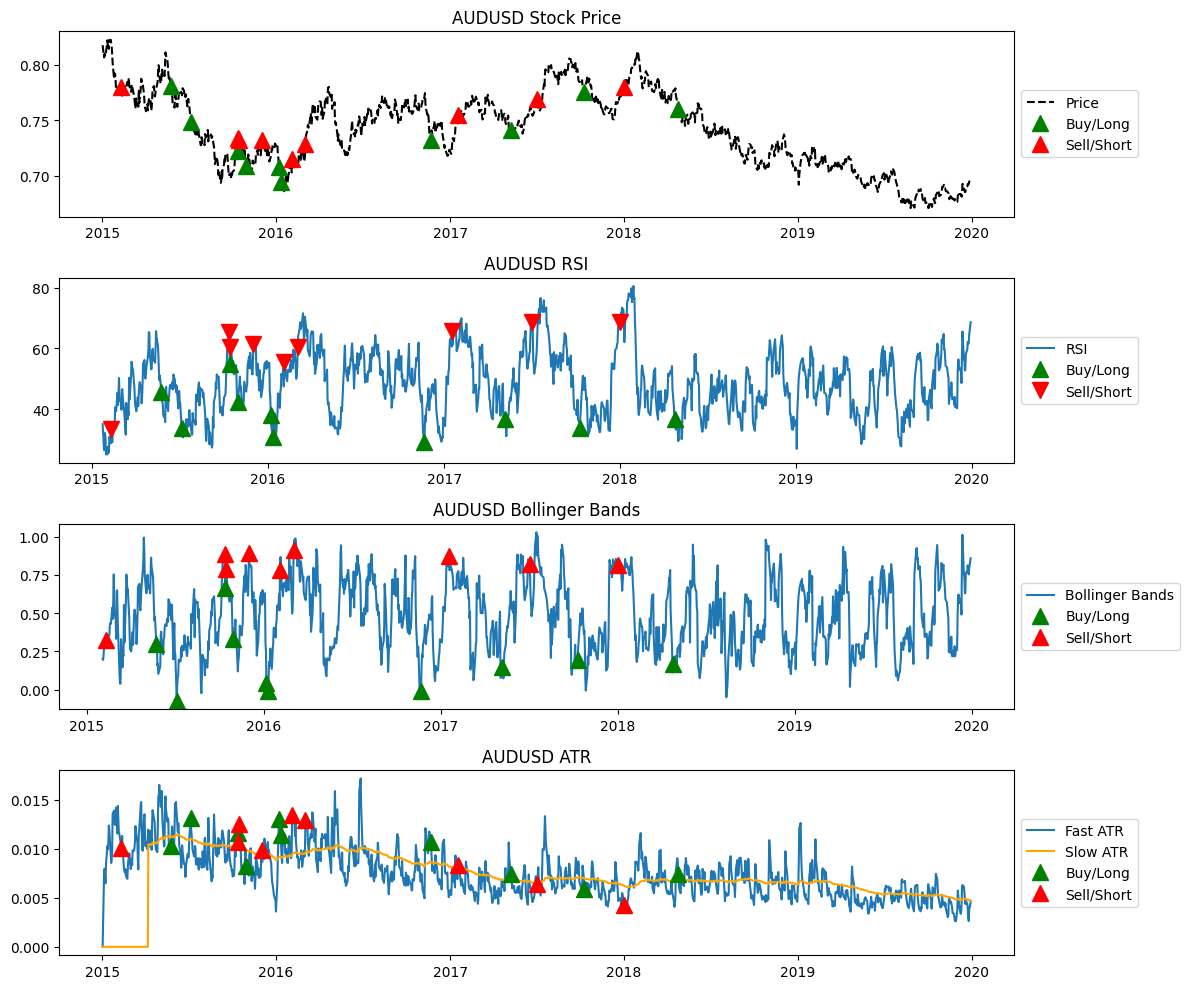

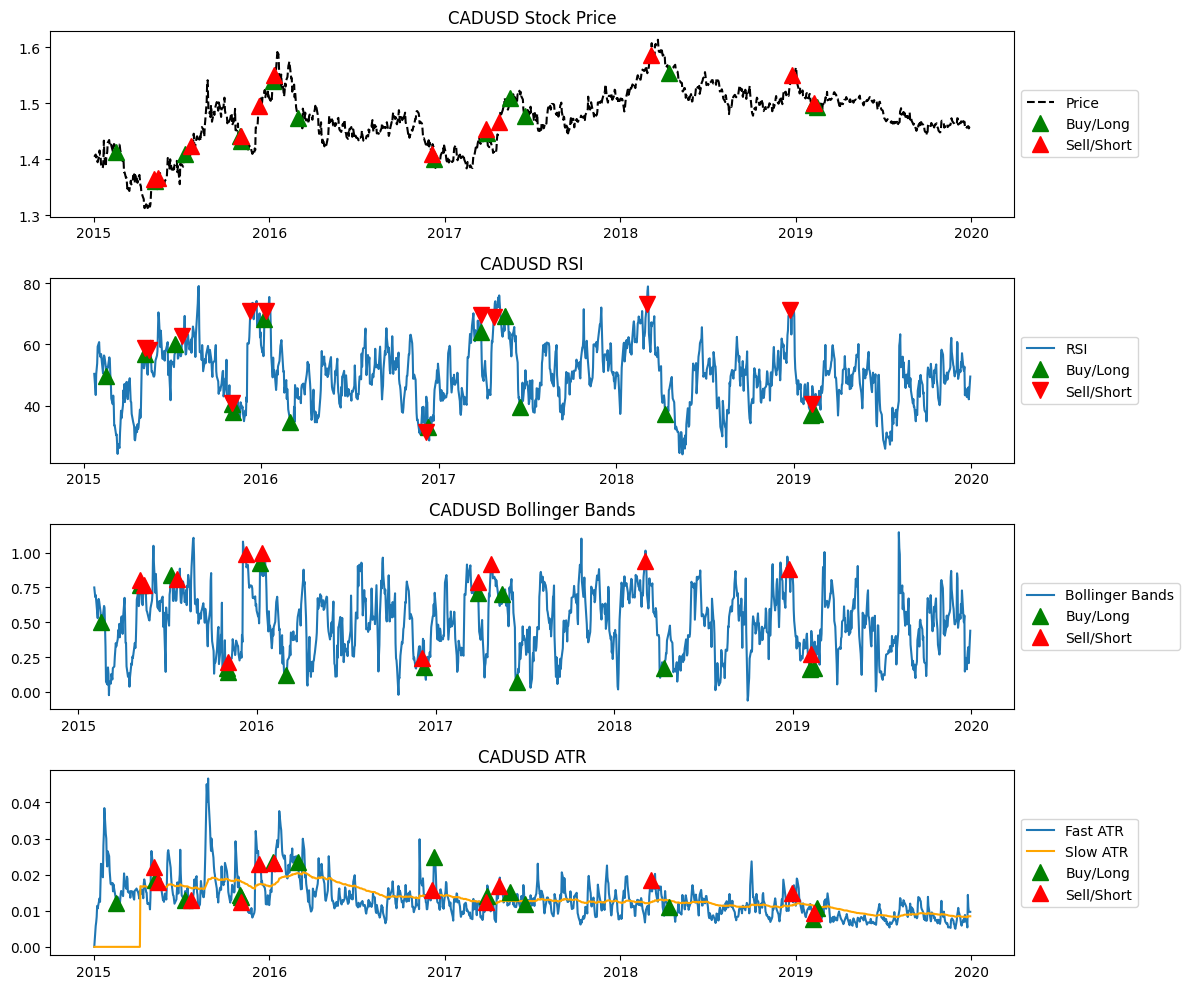

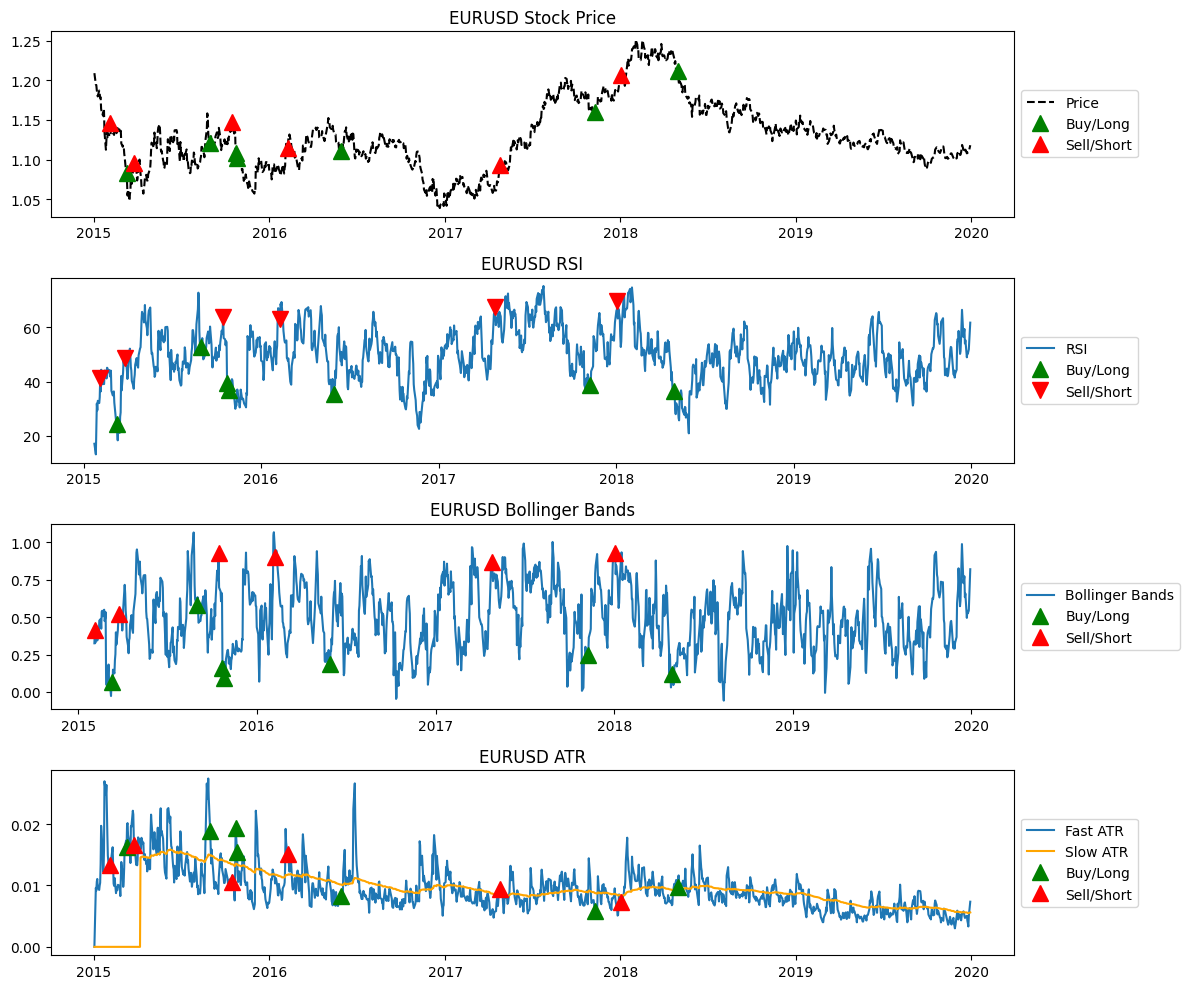

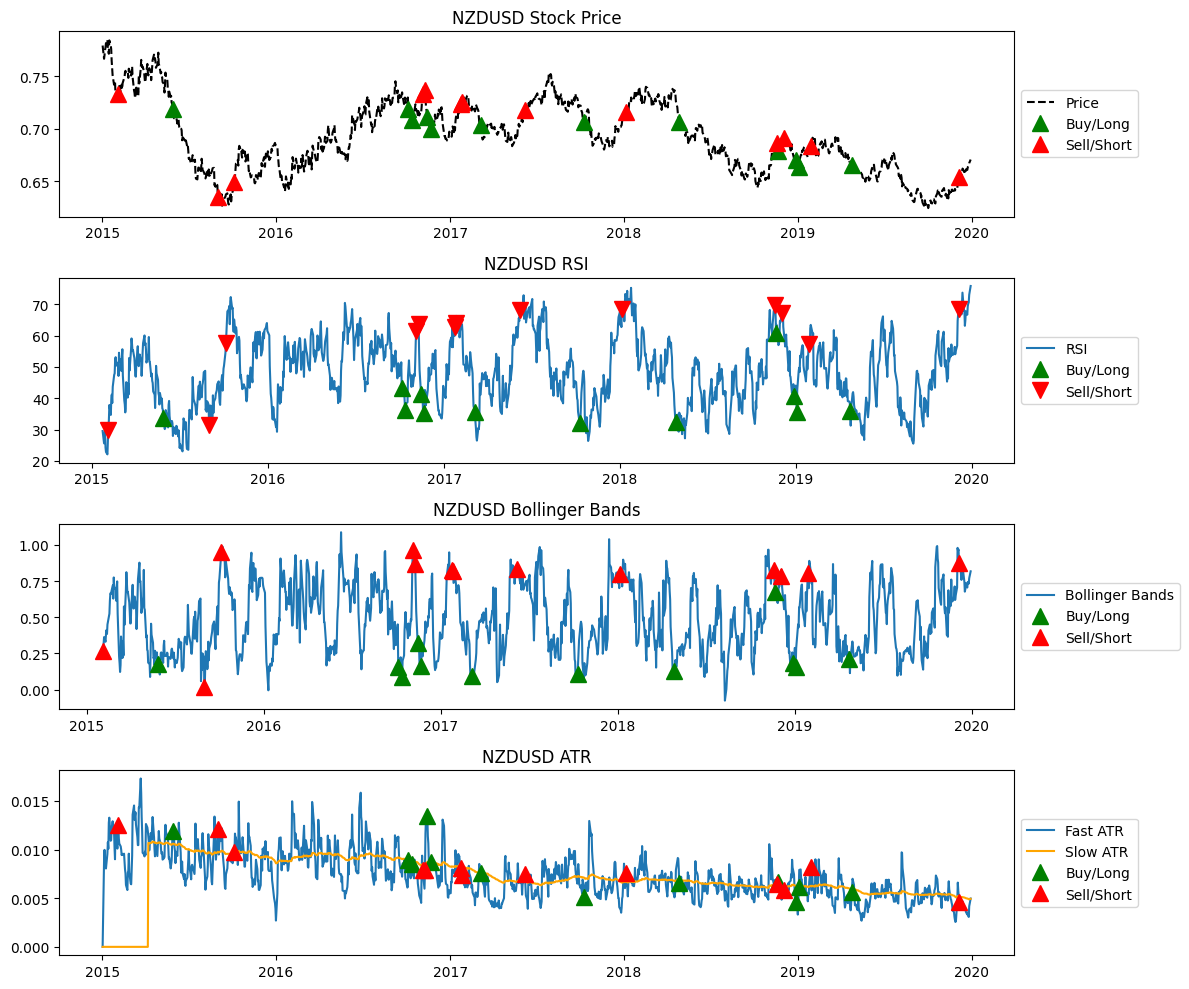

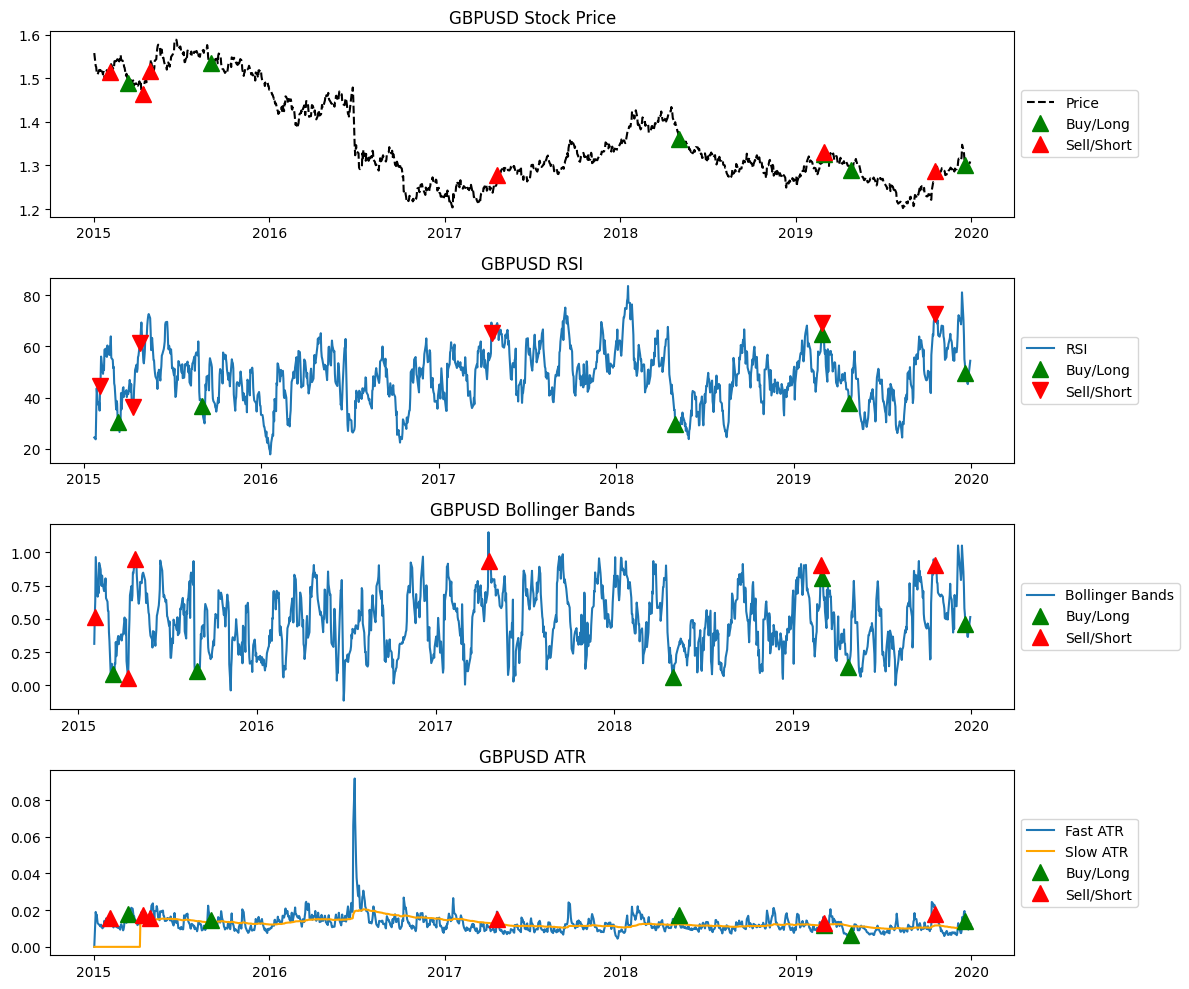

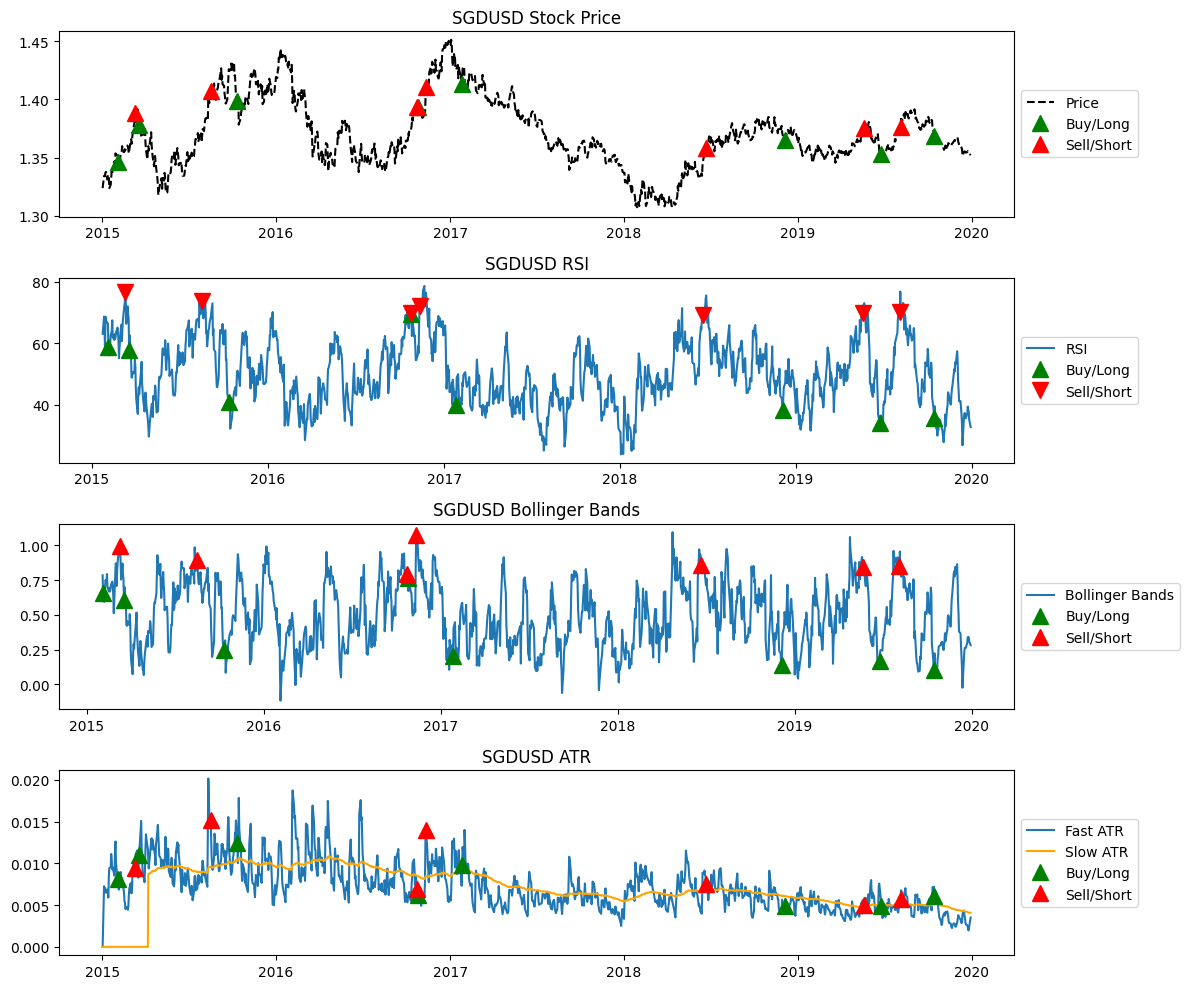

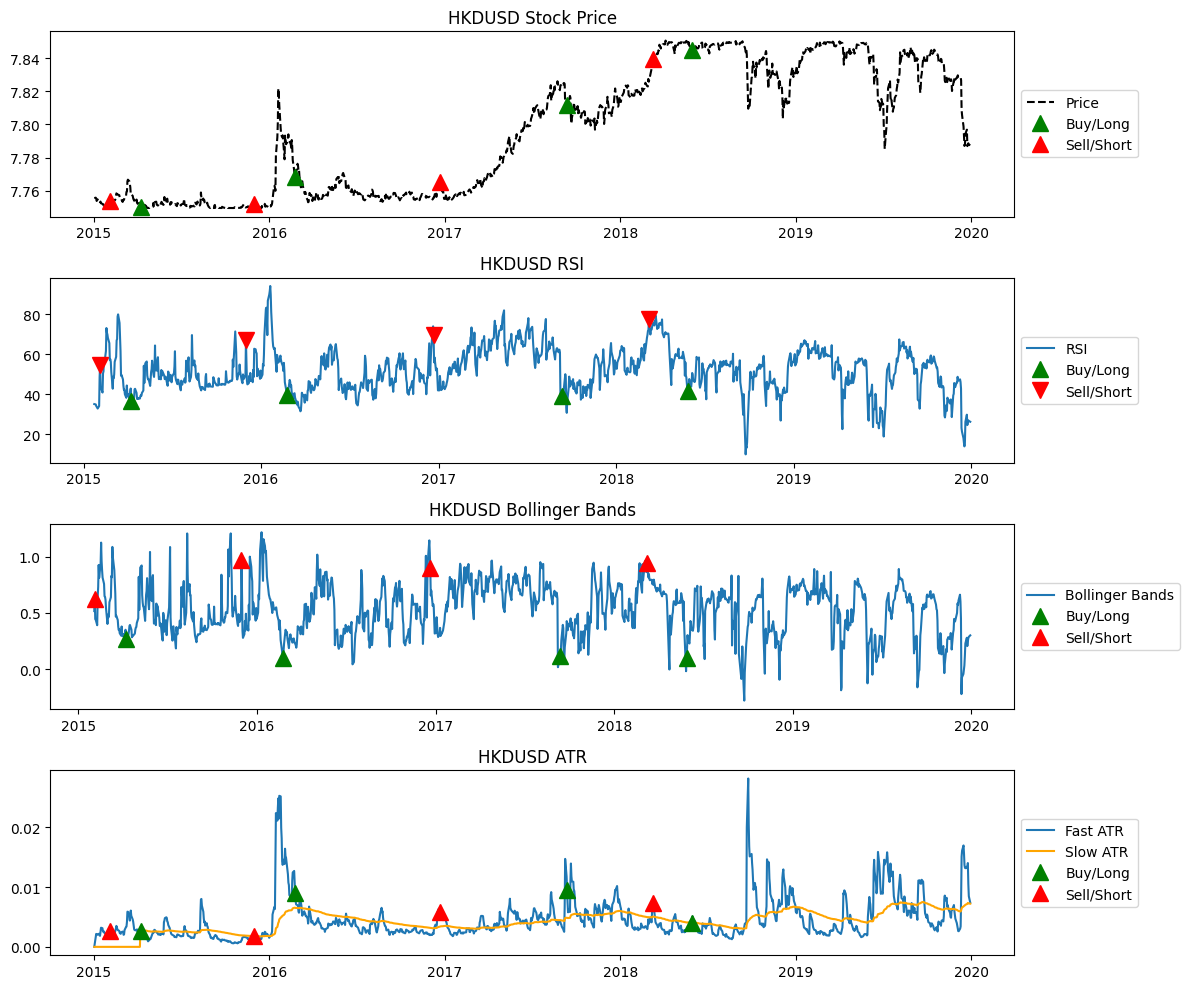

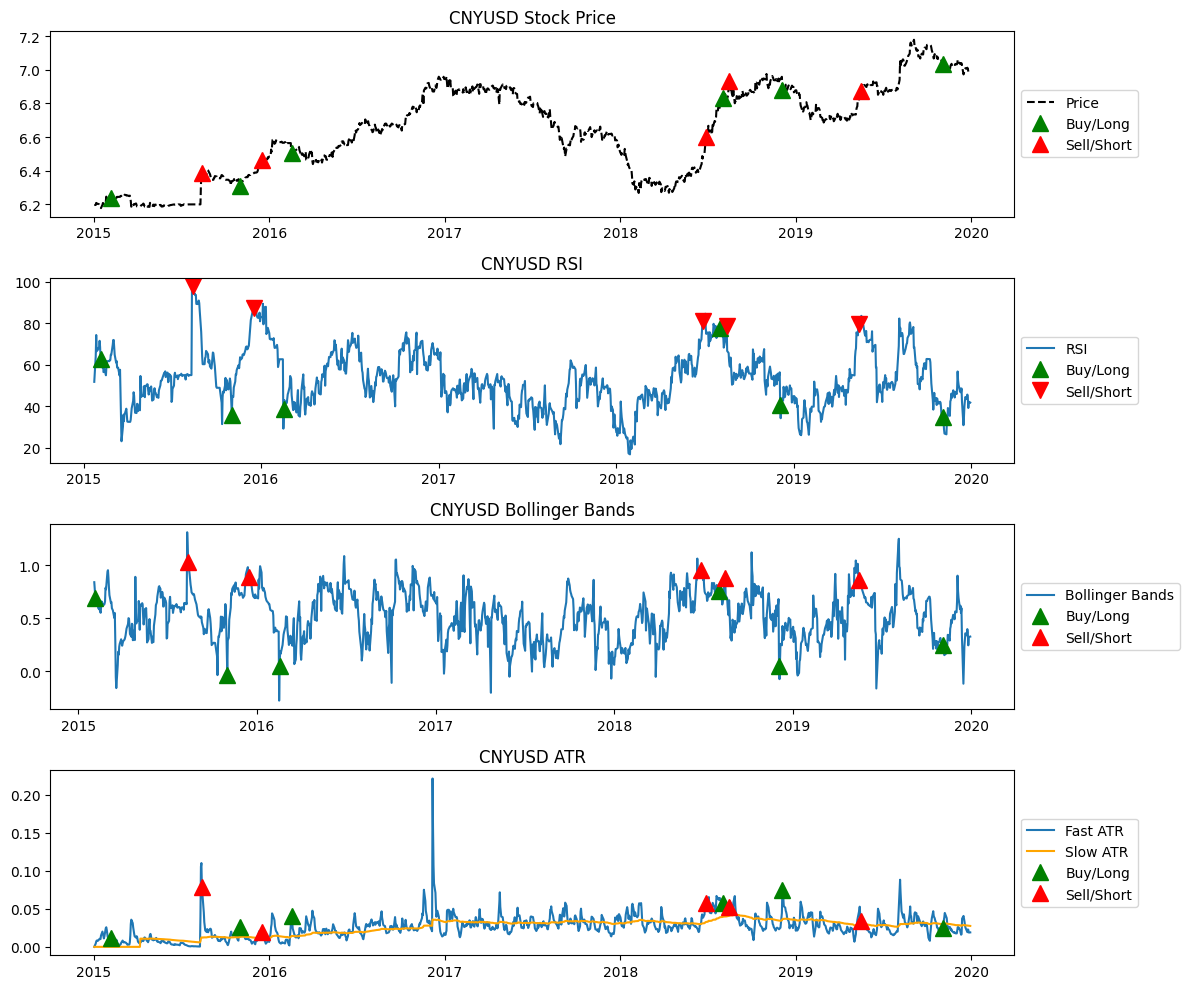

In [99]:
for symbol in forex_pairs_dict:
 df = strategy.data[symbol].copy()

 df['signal'] = df.Positions.diff()
 # Create a separate plot for each stock symbol
 plt.figure(figsize=(12, 10))

 # Plot Stock Price
 plt.subplot(4, 1, 1)
 plt.title(symbol + ' Stock Price')
 plt.plot(df["Close_Price"] ,color='black', label='Price', linestyle='dashed')
 plt.plot(df[df['signal'] > 0].index,
         df["Close_Price"][df['signal'] > 0],
         '^', markersize=12, color = 'g', label = 'Buy/Long')
 plt.plot(df[df['signal'] < 0].index,
         df["Close_Price"][df['signal'] < 0 ],
         '^', markersize=12, color = 'r', label = 'Sell/Short')
 plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

 # Plot RSI
 plt.subplot(4, 1, 2)
 plt.plot(df.rsi, label='RSI')
 plt.title(symbol + ' RSI')
 plt.plot(df[df['signal'] > 0].index,
        df["rsi"][df['signal'] > 0],
        '^', markersize=12, color='g', label='Buy/Long')
 plt.plot(df[df['signal'] < 0].index,
        df["rsi"][df['signal'] < 0],
        'v', markersize=12, color='r', label='Sell/Short')
 plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

 # Plot Bollinger Bands
 plt.subplot(4, 1, 3)
 plt.plot(df.bollinger, label='Bollinger Bands')
#  plt.plot(df.bb_lower, label='Low Bound')
#  plt.plot(df.bb_upper, label='Upper Bound')
 plt.title(symbol + ' Bollinger Bands')
 plt.plot(df[df['signal'] > 0].index,
         df["bollinger"][df['signal'] > 0],
         '^', markersize=12, color = 'g', label = 'Buy/Long')
 plt.plot(df[df['signal'] < 0].index,
         df["bollinger"][df['signal'] < 0 ],
         '^', markersize=12, color = 'r', label = 'Sell/Short')
 plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#Plot Fast & Slow ATR
 plt.subplot(4, 1, 4)
 plt.plot(df.Fast_ATR, label='Fast ATR')
 plt.plot(df.Slow_ATR, label='Slow ATR', color = 'orange')
 plt.title(symbol + ' ATR')
 plt.plot(df[df['signal'] > 0].index,
         df["Fast_ATR"][df['signal'] > 0],
         '^', markersize=12, color = 'g', label = 'Buy/Long')
 plt.plot(df[df['signal'] < 0].index,
         df["Fast_ATR"][df['signal'] < 0 ],
         '^', markersize=12, color = 'r', label = 'Sell/Short')
 plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


 # Display descriptive statistics
#  display(df.describe())


 # Show the individual plot for the current stock symbol
 plt.tight_layout()
 plt.show()



In [ ]:
|